# Unit Testing Optimisation

## Importing the Packages

In [24]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.use("pgf")
%matplotlib inline
plt.plot([1, 2, 3])
mpl.use("pgf")
mpl.rcParams.update(
    {
        "pgf.texsystem": "lualatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "pgf.preamble": "\n".join(
            [
                r"\usepackage{bm}",
                r"\usepackage{mathtools}",
                r"\usepackage{amsmath}",
                r"\DeclarePairedDelimiter\abs{\lvert}{\rvert}%",
                r"\DeclarePairedDelimiter\norm{\lVert}{\rVert}",
                r"\makeatletter",
                r"\let\oldabs\abs",
                r"\def\abs{\@ifstar{\oldabs}{\oldabs*}}",
                r"\let\oldnorm\norm",
                r"\def\norm{\@ifstar{\oldnorm}{\oldnorm*}}",
                r"\makeatother",
                r"\usepackage[dvipsnames]{xcolor}", 
                r"\definecolor{myred}{RGB}{205, 108, 46}",
            ]
        ),
        "font.serif": ["Computer Modern Roman"],
    }
)

import matplotlib.font_manager
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import Divider, Size, make_axes_locatable
import matplotlib.patches as mpatches
from mpl_toolkits import mplot3d
import matplotlib.cm as cm

import numpy as np
import scipy as sc
import scipy.io as io
from scipy.stats import multivariate_normal
from functools import partial

import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap, random, lax, value_and_grad, tree_multimap, tree_map

In [25]:
from jax.config import config
config.update("jax_enable_x64", True)

## Defining SE Covariance

In [26]:
def Squared_exp(I, J, Sigma_f, Ell):
  return Sigma_f**2.0*jnp.exp(-(I-J)**2/(2.0*Ell**2))

In [27]:
Vec_SE = jit(vmap(vmap(Squared_exp, in_axes=[None,0,None,None]),in_axes=[0,None,None,None]))

## Creating Test Data

In [28]:
key = random.PRNGKey(1)
key, *subkeys = random.split(key, 4)

In [29]:
# Time resolution
time_bin = 0.005

### Input Spike Train

In [30]:
subkeyx = subkeys[-1]

# Time horizon for input data
x_maxt = 50.0

# Maximum index of input data
k = np.floor(x_maxt/time_bin).astype(np.int64)

xtime = np.linspace(0.0, x_maxt, k + 1)

xtest = random.bernoulli(subkeyx, 0.1, (k+1,)).astype(np.float64)

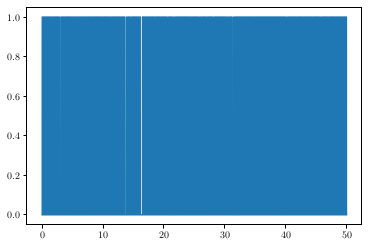

In [31]:
plt.plot(xtime, xtest)

### True Filter

In [32]:
subkeyf = subkeys[-2]

# Filter horizon
f_maxt = 0.25

# Maximum index of filter data
n = np.floor(f_maxt/time_bin).astype(np.int64)
ftime = np.linspace(0.0, f_maxt, n + 1)

# True filter mean
mu_true = np.zeros(n + 1)
# True filter variance
sig_true = 1.0
# True filter length scale
ell_true = 0.02

cov_true = Vec_SE(ftime, ftime, sig_true, ell_true)
chol_true = np.linalg.cholesky(cov_true + 1e-6 * np.eye(n + 1))

ftrue = mu_true + chol_true @ random.normal(subkeyf, (n + 1, ))

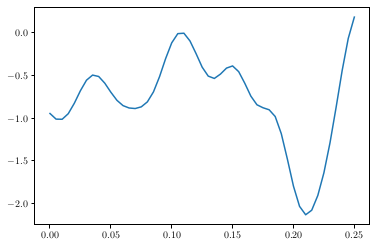

In [33]:
plt.plot(ftime, ftrue)

### True Noise

In [34]:
subkeyn = subkeys[-3]

# True noise variance
sign_true = 0.05

# Noise vector
noise_vec = sign_true * random.normal(subkeyn, (k + 1,))

### Output

In [35]:
x_pad = np.append(np.zeros(n), xtest)
ynonoise = sc.signal.convolve(np.append(np.zeros(n), xtest), ftrue, mode = 'valid')

ytest = ynonoise + noise_vec
ytime = np.linspace(0.0, x_maxt, k + 1)

In [36]:
# Showing equals the raw convolution
yffttest = np.convolve(xtest, ftrue)[:k + 1] + noise_vec

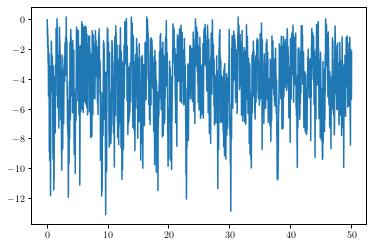

In [37]:
plt.plot(ytime, ynonoise)

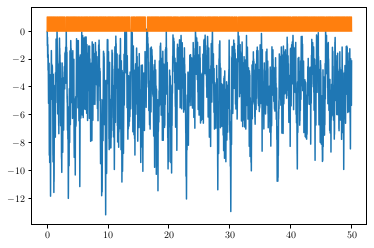

In [38]:
plt.plot(ytime, ytest)
plt.plot(xtime, xtest)

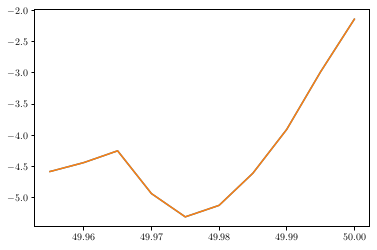

In [39]:
plt.plot(ytime[-10:], yffttest[-10:])
plt.plot(ytime[-10:], ytest[-10:])

## Variational Inference

### ELBO

#### Kl Divergence Term

In [40]:
@jit
def KL_Term(L_Matrix, V_Vector, M):
  return 0.5 * (- jnp.sum(jnp.log(jnp.diag(L_Matrix) ** 2)) + \
                jnp.sum(L_Matrix ** 2) + jnp.sum(V_Vector ** 2) - M)

#### Log-Likelihood

In [41]:
@partial(jit, static_argnums = (2, 3, ))
def Log_Likelihood(F_Test, Sigma_n, N, K, Y_Test, X_Pad):

  Mean = jsc.signal.convolve(X_Pad, F_Test, mode = 'valid')
  
  return - 0.5 * ((K + 1) * jnp.log(2 * jnp.pi * Sigma_n ** 2) + \
                  jnp.sum((Y_Test - Mean)**2)/(Sigma_n ** 2))

In [42]:
Vec_LL = jit(vmap(Log_Likelihood, in_axes = [0, None, None, None, None, None]),
             static_argnums = (2,3,))

In [43]:
test_mean = np.convolve(np.ones(10), np.arange(10))

In [44]:
print(Log_Likelihood(np.append(ftrue, np.zeros(k)), sign_true, n, k, ytest, x_pad))

-17289426.253002446


#### Expected Log-Likelihood

In [45]:
@partial(jit, static_argnums = range(6,10))
def Expected_Term(Sigma_f, Ell, Sigma_n, Z_Vector, V_Vector, L_Matrix, Number_F,
                  M, N, K, Y_Test, X_Fft, F_Time, Subkey):

  K_MM = Vec_SE(Z_Vector, Z_Vector, Sigma_f, Ell)
  K_MN = Vec_SE(Z_Vector, F_Time, Sigma_f, Ell)
  C = jnp.linalg.cholesky(K_MM + 1e-6 * jnp.eye(M)) 
  K_NN = Vec_SE(F_Time, F_Time, Sigma_f, Ell)
  
  B = jsc.linalg.solve_triangular(C, K_MN, lower = True)

  Mu_q = V_Vector @ B
  V_q = K_NN + B.T @ (L_Matrix @ L_Matrix.T - jnp.eye(M)) @ B

  Chol_Vq = jnp.linalg.cholesky(V_q + 1e-6 * jnp.eye(N + 1))

  F_Samples = Mu_q + random.normal(Subkey, (Number_F, N + 1)) @ Chol_Vq.T

  F_Samples = jnp.hstack((F_Samples, jnp.zeros((Number_F, K))))

  Likelihoods = Vec_LL(F_Samples, Sigma_n, N, K, Y_Test, X_Fft)

  return jnp.mean(Likelihoods)

In [46]:
test_number_f = 20000
test_m = int(1000)
test_key = random.PRNGKey(0)
test_sigma_f = 1.0
test_ell_f = 0.01
test_sigma_n = 0.05
test_z_m = np.linspace(0.0, ftime[-1], test_m)
test_v_m = np.zeros(test_m)
test_l_mm = np.eye(test_m)

In [47]:
print(Expected_Term(test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m, test_l_mm, test_number_f, test_m, n, k, ytest, x_pad, ftime, test_key))

-51579643.30010398


#### ELBO

In [48]:
@partial(jit, static_argnums = range(7, 11))
def Neg_ELBO(Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, Number_F,
         M, N, K, Y_Test, X_Pad, F_Time, Subkey):

  Square_Frac = Z_Fractions ** 2.0
  Z_Vector = ((Square_Frac) / jnp.max(Square_Frac)) * F_Time[-1]

  D = jnp.diag(jnp.exp(L_Diag))

  L_Matrix = (D + jnp.zeros((M, M))).at[jnp.tril_indices(M, -1)].set(L_ODiag)

  KL = KL_Term(L_Matrix, V_Vector, M)
  Exp = Expected_Term(Sigma_f, Ell, Sigma_n, Z_Vector, V_Vector, L_Matrix,
                      Number_F, M, N, K, Y_Test, X_Pad, F_Time, Subkey)
  
  return (KL-Exp)/(K + 1)

In [49]:
test_number_f = 10000
test_m = 1000
test_key = random.PRNGKey(0)
test_sigma_f = 2.0
test_ell_f = 0.7
test_sigma_n = 0.01
test_z_m = np.linspace(0.0, ftime[-1], test_m)
test_v_m1 = np.zeros(test_m)
test_v_m2 = 5.0 * np.ones(test_m)
test_l_diag = np.ones(test_m)
test_l_odiag = np.tril(np.zeros((test_m, test_m)), -1)[np.tril_indices(test_m, -1)]

In [50]:
print(Neg_ELBO(test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m2, test_l_diag, test_l_odiag, test_number_f, test_m, n, k, ytest, x_pad, ftime, test_key))

97663572.66073592


In [51]:
Grad_Bound = jit(grad(Neg_ELBO, argnums = range(7)), static_argnums = range(7, 11))

In [52]:
i = 1

In [53]:
%timeit -n 20 -r 10 test_grad = Grad_Bound(test_sigma_f * i, test_ell_f * i, test_sigma_n * i, test_z_m, test_v_m2 * i, test_l_diag, test_l_odiag, test_number_f, test_m, n, k, ytest, x_pad, ftime, test_key)

KeyboardInterrupt: 